# Take a look at NDVI for Vancouver on Aug 11, 2016 

* NDVI is defined as (red - nearir)/(red + nearir) -- where red is first channel and nearir is the second channel for MODIS.  See [Wikipedia on NDVI](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index)

* [Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php)

* Band 1 centered at 0.645 microns (red), band 2 centered at 0.86 microns (near IR)

* data acquired at 250 m resolution, resampled to 1 km for the MYD021KM file

In [1]:
from e582utils.data_read import download
from e582lib.modis_chans import chan_dict

import numpy as np
import h5py
import sys
import warnings
from matplotlib import pyplot as plt
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
from e582lib.channels_reproject import subsample,find_corners
%matplotlib notebook
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)


MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite



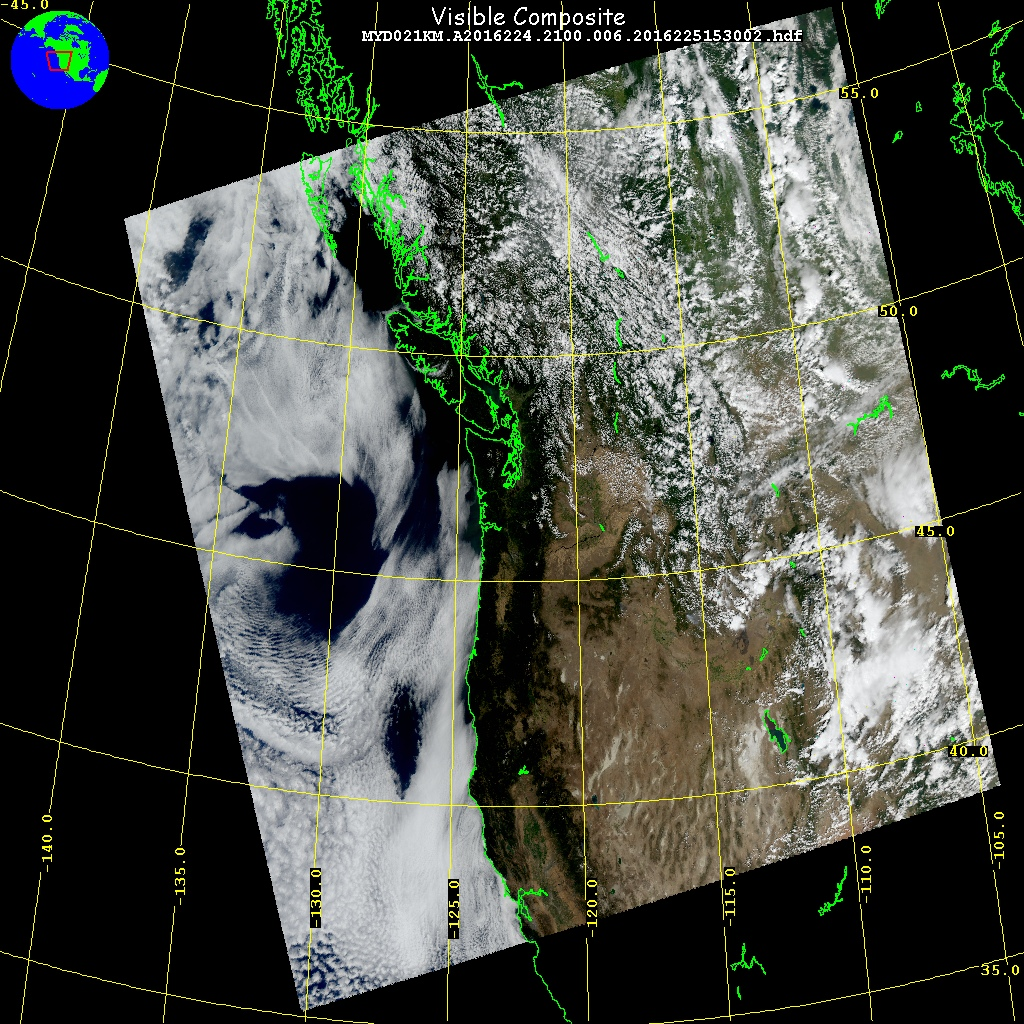

In [2]:
Image('figures/MYBRGB.A2016224.2100.006.2016237025650.jpg')

In [3]:
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)


MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



### Calibrate and resample the channel 1 and channel 2 reflectivities



In [4]:
chan_list=['1','2']
reflectivity_list=[]
for the_chan in chan_list:
    #
    # read channel channels
    #
    index = chan_dict[the_chan]['index']
    field_name = chan_dict[the_chan]['field_name']
    scale_name = chan_dict[the_chan]['scale']
    offset_name = chan_dict[the_chan]['offset']
    with h5py.File(myd02file, 'r') as h5_file:
        chan = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][field_name][
            index, :, :]
        scale = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[scale_name][...]
        offset = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[offset_name][...]
        chan_calibrated = (chan - offset[index]) * scale[index]
        chan_calibrated = chan_calibrated.astype(
            np.float32)  #convert from 64 bit to 32bit to save space
        reflectivity_list.append(chan_calibrated)

with h5py.File(myd03file) as geo_file:
        lon_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Longitude'][...]
        lat_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Latitude'][...]
    #            


In [5]:
reflectivity_list

[array([[ 0.54183537,  0.38102648,  0.11691552, ...,  0.27081758,
          0.32051671,  0.09078971],
        [ 0.42757249,  0.20965716,  0.21496241, ...,  0.21165913,
          0.19093867,  0.11156023],
        [ 0.24033748,  0.26771453,  0.28057724, ...,  0.14068902,
          0.23848565,  0.25510207],
        ..., 
        [ 0.06341266,  0.06055984,  0.05915846, ...,  0.35374954,
          0.36295864,  0.39428958],
        [ 0.059709  ,  0.05895825,  0.05795727, ...,  0.35995567,
          0.36365932,  0.40595111],
        [ 0.06496419,  0.05860791,  0.05595529, ...,  0.34879464,
          0.35710284,  0.40174696]], dtype=float32),
 array([[ 0.58955914,  0.45894516,  0.18011184, ...,  0.28703269,
          0.34215218,  0.07519285],
        [ 0.48389974,  0.27600878,  0.3052139 , ...,  0.21844868,
          0.19415224,  0.09940704],
        [ 0.31738955,  0.35295668,  0.39244527, ...,  0.13524842,
          0.24932656,  0.26811108],
        ..., 
        [ 0.14410593,  0.13623564,  0

In [6]:
llcrnr=dict(lat=45,lon= -125)
urcrnr=dict(lat=50,lon= -120)
subsample_list=subsample(*reflectivity_list,lats=lat_data,lons=lon_data,llcrnr=llcrnr,urcrnr=urcrnr)
lats,lons=subsample_list[:2]
numchans=len(subsample_list) -2
rows,cols=lats.shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=subsample_list[chan+2]


here is lats:  (2030, 1354)
(622,) (195201,)
here is lats:  (621, 473)


In [7]:
corner_dict=find_corners(subsample_list[0],subsample_list[1])
corner_dict

{'lat_0': 47.459999084472656,
 'lat_list': [44.227749, 50.692249],
 'llcrnrlat': 44.227749,
 'llcrnrlon': -127.23767,
 'lon_0': -122.78046417236328,
 'lon_list': [-127.23767, -118.32326],
 'urcrnrlat': 50.692249,
 'urcrnrlon': -118.32326}

In [8]:
proj_id = 'laea'
datum = 'WGS84'
lat_0_txt = '{lat_0:5.2f}'.format_map(corner_dict)
lon_0_txt = '{lon_0:5.2f}'.format_map(corner_dict)
area_dict = dict(
    datum=datum, lat_0=lat_0_txt, lon_0=lon_0_txt, proj=proj_id, units='m')
area_dict

{'datum': 'WGS84',
 'lat_0': '47.46',
 'lon_0': '-122.78',
 'proj': 'laea',
 'units': 'm'}

In [9]:
from e582lib.channels_reproject import resample_channels
chan_list=['1','2']
result_dict=\
       resample_channels(chan_array,lats,lons,corner_dict)

running resample_chans: here are the mean values of the channels to be resampled
channum and mean 0 0.08828555792570114
channum and mean 1 0.17723390460014343
pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '47.46', 'lon_0': '-122.78', 'proj': 'laea', 'units': 'm'}
Number of columns: 516
Number of rows: 552
Area extent: (-356053.49092468648, -349176.13967279287, 314848.12496328872, 368519.51194260316)


x and y pixel dimensions in meters:
1300.1969300154558
1300.1732819119493

completed modisl1b_resample


In [10]:
result_dict.keys()

dict_keys(['area_def_args', 'fill_value', 'geotiff_args', 'channels', 'basemap_args'])

### Write this resampled data out to hdf5 for future reuse

In [11]:
# out_file=make_projectname(myd02file,chan_list)
# print('ready to write {}'.format(out_file))
# print('result_dict dictionary keys: '.format(result_dict.keys()))
# print('remapped channel shape: ',result_dict['channels'].shape)
# result_dict['out_file']=out_file
# result_dict['in_file']=myd02file
# result_dict['chan_list']=chan_list

# write_h5(**result_dict)


### Now use the red and nearir channels to get the ndvi

In [12]:
ch1=result_dict['channels'][:,:,0]
ch2=result_dict['channels'][:,:,1]
ndvi = (ch2 - ch1)/(ch2 + ch1)

### check out the correlation using a 2-d histogram

In [13]:
from e582lib.geolocate import fast_hist, fast_count
ch1_min= 0.
ch1_max = 1.
num_ch1_bins=120

ch2_min = 0
ch2_max = 0.8
num_ch2_bins=100

ch1_hist = fast_hist(ch1.ravel(),ch1_min,ch1_max,numbins=num_ch1_bins)
ch2_hist =  fast_hist(ch2.ravel(),ch2_min,ch2_max,numbins=num_ch2_bins)
heatmap = fast_count(ch2_hist,ch1_hist)



### Why the strong correlation between channels 1 and 2?

Even the same surface can have very different reflectance values as the sun-satellite angle changes.  These changes due to geometry affect both channel 1 and channel 2 approximately equally.   That is why need to remove this spurious variability by creating the the "normalized" vegetation difference index.  By ratioing
(chan2 - chan1)/(chan2 + chan1) you remove much of the change due to geometry -- the difference between high and low reflectivities is smoothed, as long as it occurs in both channels.

Below we'll use the "perceptually uniform" magma colormap. For other colormap choices see:

http://matplotlib.org/users/colormaps.html

<IPython.core.display.Javascript object>


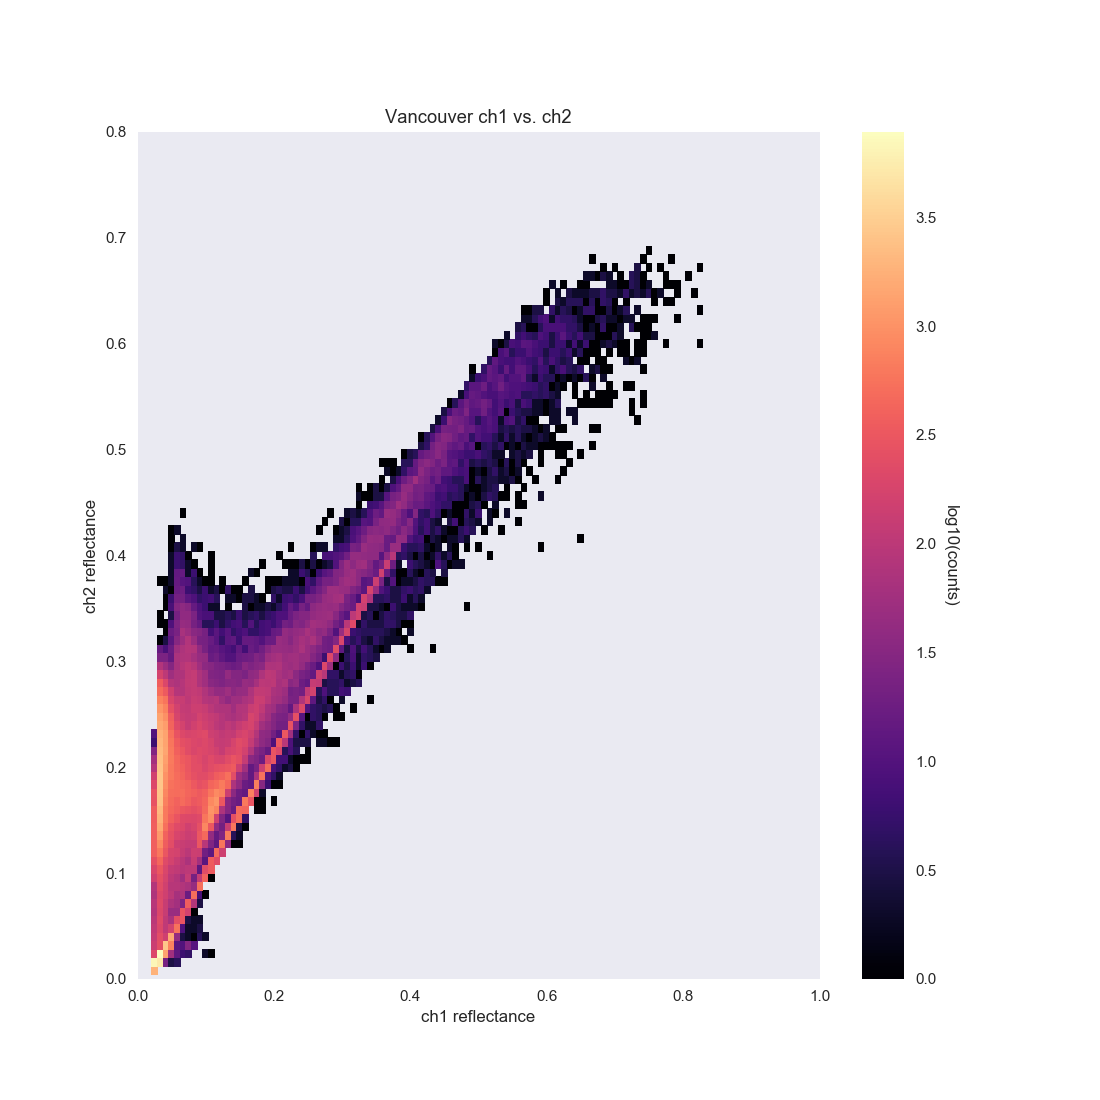

In [14]:

cmap=cm.get_cmap('magma')
with np.errstate(divide='ignore'): #use a context manager (with)
    log_counts=np.log10(heatmap)  #turn off divide by zero warning
masked_counts = np.ma.masked_invalid(log_counts)
fig, ax = plt.subplots(1,1,figsize=(10,10))
CS=ax.pcolormesh(ch1_hist['centers_vec'],ch2_hist['centers_vec'],masked_counts,cmap=cmap)
cax=fig.colorbar(CS,ax=ax)
ax.set(xlim=(0,1.),ylim=(0,0.8))
out=cax.ax.set_ylabel('log10(counts)')
out.set_rotation(270)
out.set_verticalalignment('bottom')
ax.set(xlabel='ch1 reflectance',ylabel='ch2 reflectance',
       title='Vancouver ch1 vs. ch2');



<IPython.core.display.Javascript object>


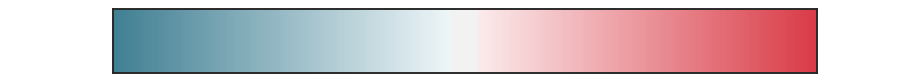

In [15]:
interactive=True
if interactive:
    sns.choose_diverging_palette(as_cmap=True);

In [16]:
cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('c')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('k',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

<IPython.core.display.Javascript object>


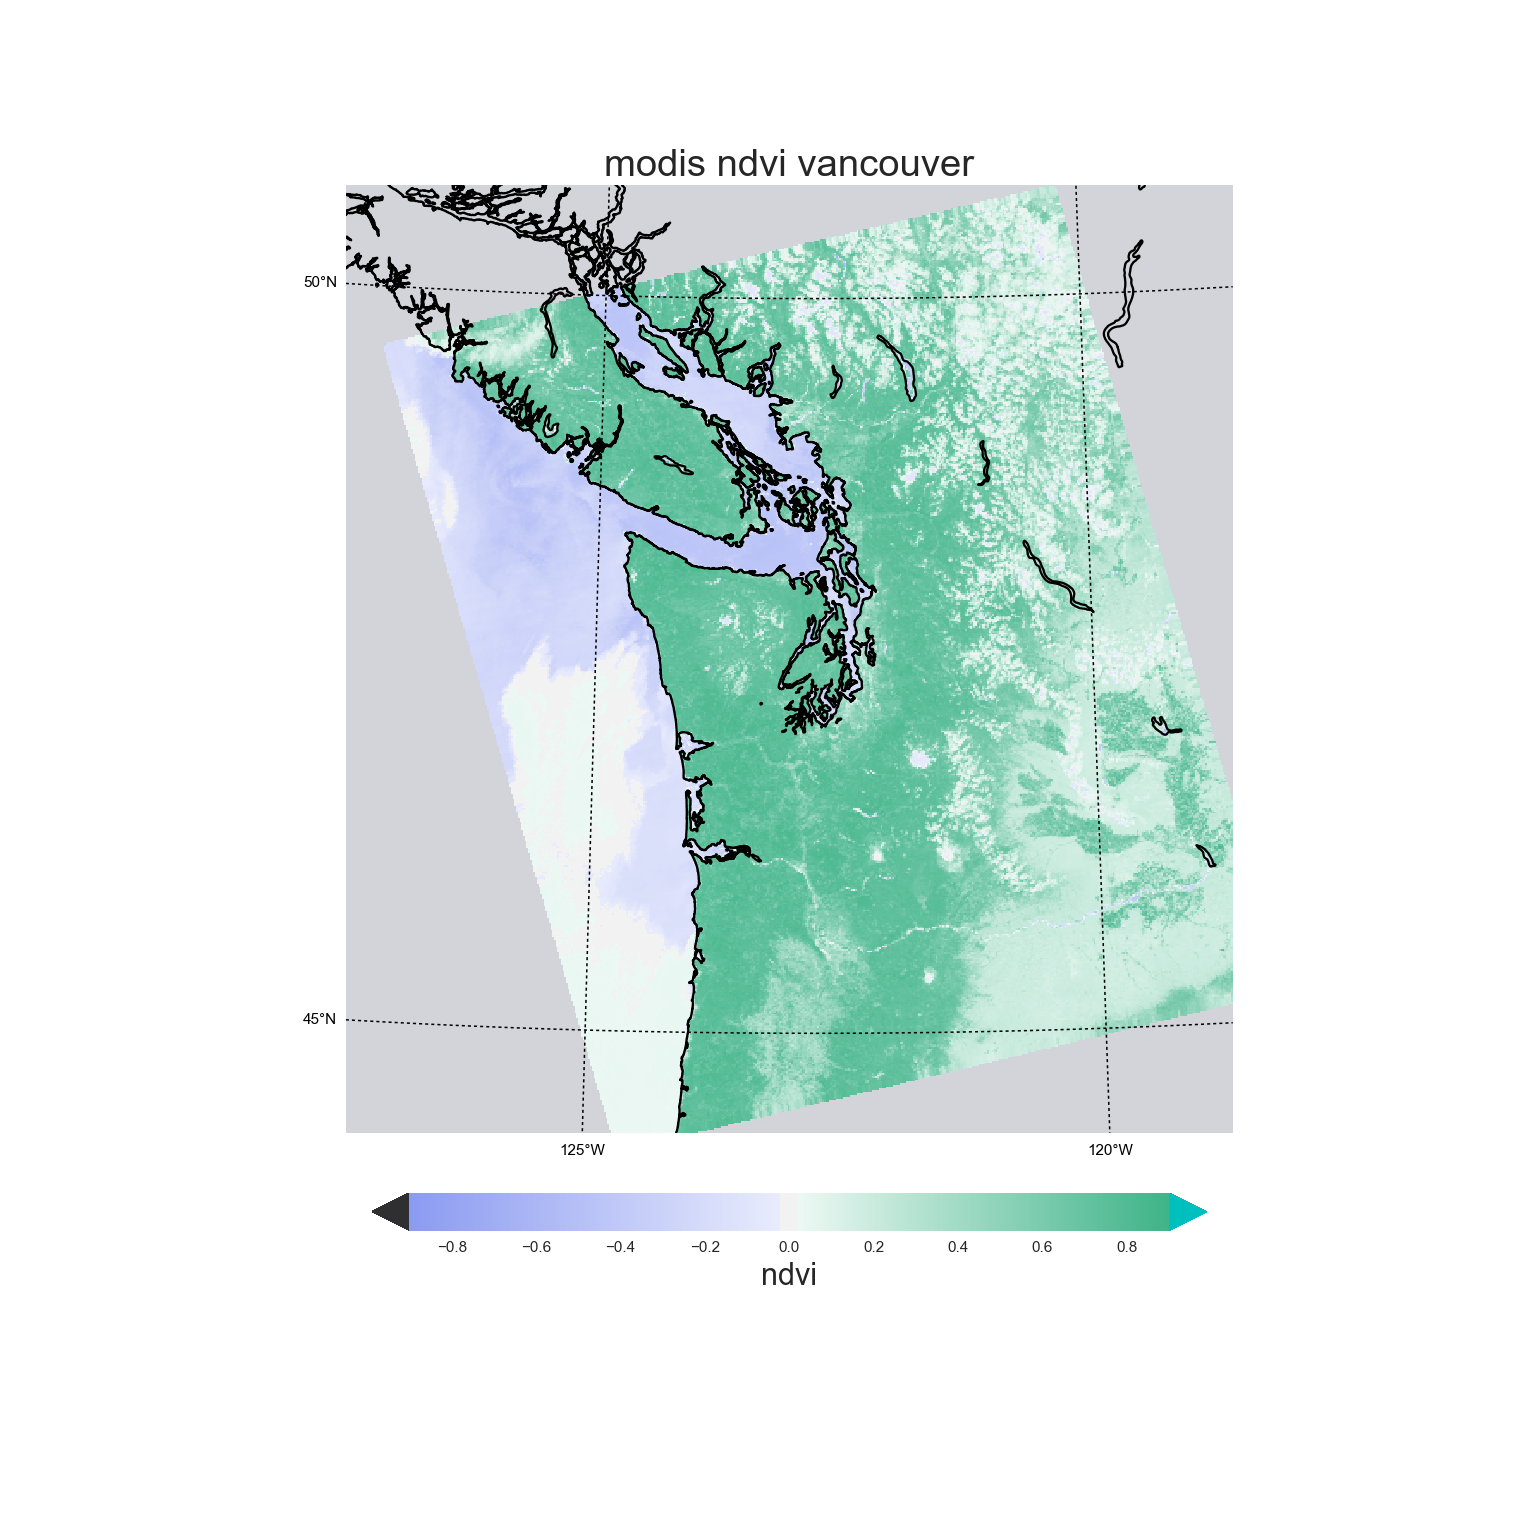

{'ticklocation': 'bottom', 'orientation': 'horizontal'}


In [20]:
masked_ndvi = np.ma.masked_invalid(ndvi)
fig,ax=plt.subplots(1,1,figsize=(14,14))
basemap_args=result_dict['basemap_args']
basemap_args['ax']=ax
basemap_args['resolution']='f'
bmap=Basemap(**basemap_args)
lat_sep,lon_sep= 5,5
parallels = np.arange(30, 60, lat_sep)
meridians = np.arange(-135, -100, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                       fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    col = bmap.imshow(masked_ndvi,origin='upper', norm=the_norm,cmap=cmap)
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    out=fig.colorbar(col,cax=cax,extend='both',**kw)
    out.set_label('ndvi',size=20)
    ax.set_title('modis ndvi vancouver',size=25)
    print(kw)
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='k')


In [18]:
dir(bmap)
bmap.xmin,bmap.xmax,bmap.ymin,bmap.ymax
bmap.proj4string

'+lat_0=47.459999084472656 +a=6378137.0 +y_0=349178.1304775582 +lon_0=-122.78046417236328 +b=6356752.314245179 +x_0=356016.46293302625 +proj=laea +units=m '

### can save some time by reusing the bmap instance with a new axis

<IPython.core.display.Javascript object>


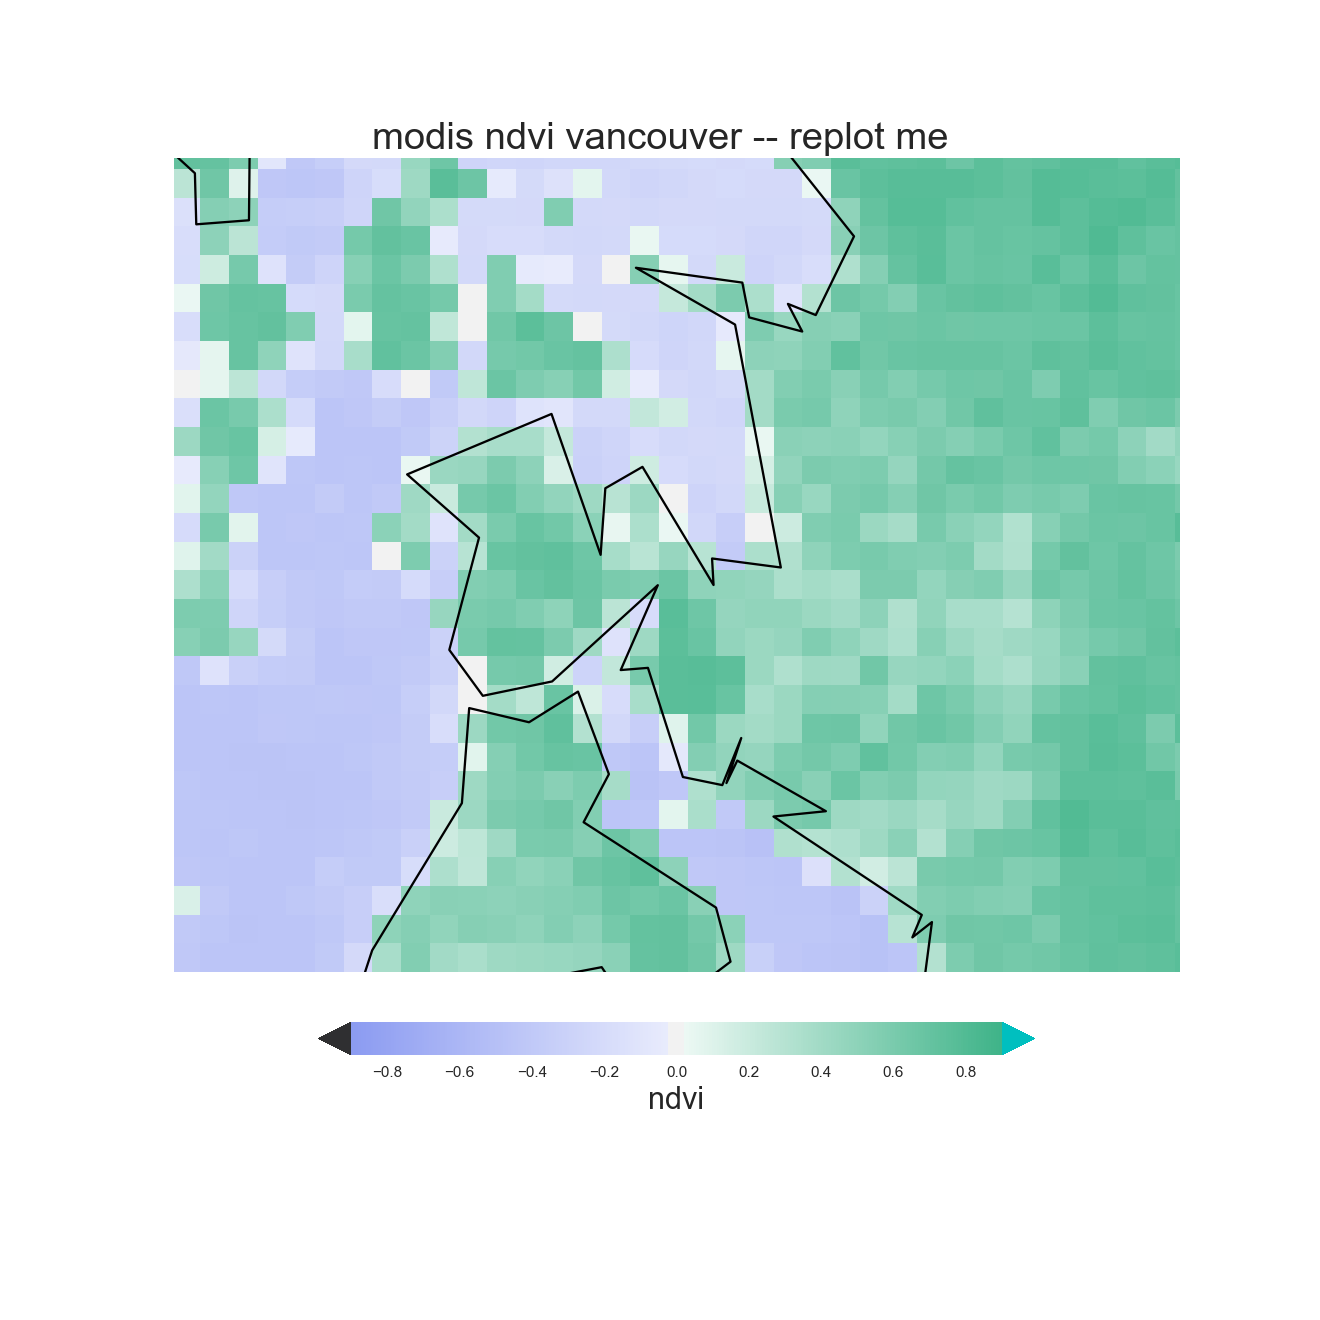

{'ticklocation': 'bottom', 'orientation': 'horizontal'}


In [19]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
bmap.ax=ax
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    col = bmap.imshow(masked_ndvi,origin='upper', norm=the_norm,cmap=cmap)
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    out=fig.colorbar(col,cax=cax,extend='both',**kw)
    out.set_label('ndvi',size=20)
    ax.set_title('modis ndvi vancouver -- replot me   ',size=25)
    print(kw)
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='k');

In [22]:
import pickle
pkl_file='map.pkl'
pickle.dump(bmap,open(pkl_file,'wb'),-1)

<IPython.core.display.Javascript object>


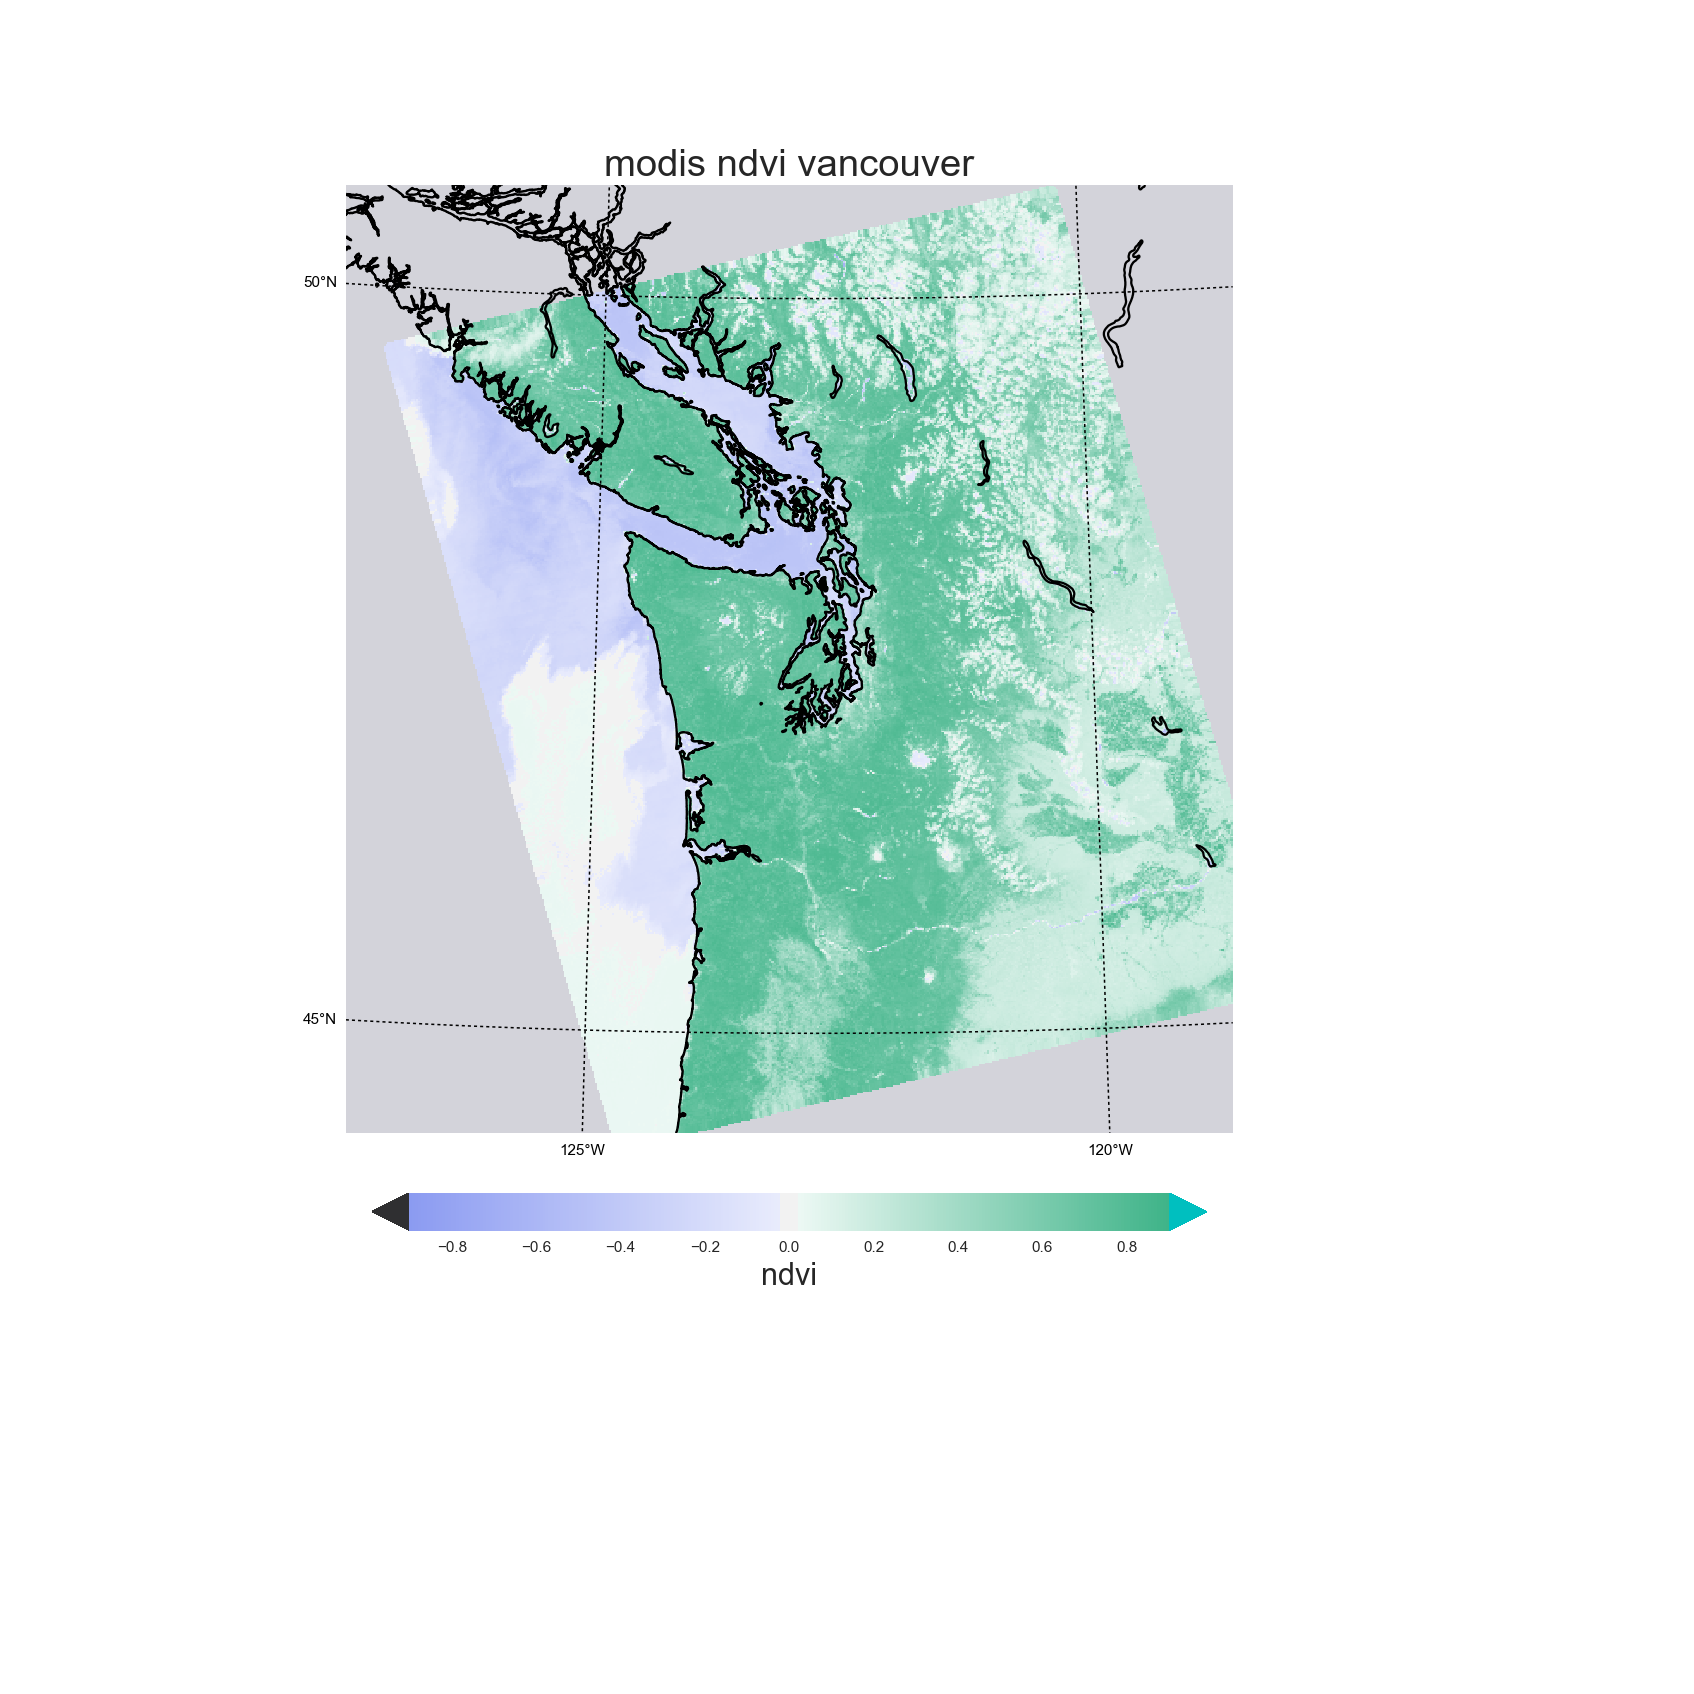

In [23]:
bmap_new = pickle.load(open(pkl_file,'rb'))